In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time
from IPython.core.debugger import set_trace
from torchvision import datasets, transforms
from tensorboardX import SummaryWriter
from model import Net, ConvNet
from lbfgsb import *
device = torch.device("cpu")

In [2]:
np.random.seed(42)
torch.manual_seed(42)

In [3]:
# loading the dataset
# note that this time we do not perfrom the normalization operation, see next cell
test_dataset = datasets.MNIST('mnist_data/', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))

In [4]:
class Normalize(nn.Module):
    def forward(self, x):
        return (x - 0.1307)/0.3081

# we load the body of the neural net trained last time...
NN1_logits = torch.load('model_conv.net', map_location='cpu') 
NN2_logits = torch.load('model_ff.net', map_location='cpu') 

# ... and add the data normalization as a first "layer" to the network
# this allows us to search for adverserial examples to the real image, rather than
# to the normalized image
NN1_logits = nn.Sequential(Normalize(), NN1_logits)
NN2_logits = nn.Sequential(Normalize(), NN2_logits)

# and here we also create a version of the model that outputs the class probabilities
NN1 = nn.Sequential(NN1_logits, nn.Softmax())
NN2 = nn.Sequential(NN2_logits, nn.Softmax())

# we put the neural net into evaluation mode (this disables features like dropout)
NN1_logits.eval()
NN2_logits.eval()
NN1.eval()
NN2.eval()

/home/manu/git/riai18/assignments/ex5/.env/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/manu/git/riai18/assignments/ex5/.env/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/manu/git/riai18/assignments/ex5/.env/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has change

Sequential(
  (0): Sequential(
    (0): Normalize()
    (1): Net(
      (fc): Linear(in_features=784, out_features=200, bias=True)
      (fc2): Linear(in_features=200, out_features=10, bias=True)
    )
  )
  (1): Softmax()
)

In [5]:
# define a show function for later
def show(result_gd, result_gd_bounds, result_lbfgsb):    
    gd_s, gd_l, gd_i, gd_t, gd_n = result_gd
    gdb_s, gdb_l, gdb_i, gdb_t, gdb_n = result_gd_bounds
    lbfgsb_s, lbfgsb_l, lbfgsb_i, lbfgsb_t = result_lbfgsb

    def print_res(title, solved, loss, i, time, it=None):
        print(title + ':')
        print('\tSolved:', solved)
        print('\tLoss:', loss)
        print('\tTime:', time, 's')        
        if it is not None:
            print('\tGradient Descent iterations:', it)
        p1 = NN1(torch.from_numpy(i).reshape((1, 1, 28, 28))).detach().numpy()
        p2 = NN2(torch.from_numpy(i).reshape((1, 1, 28, 28))).detach().numpy()
        print('\tNN1_logits class: {} (p = {:.2f}) '.format(p1.argmax(), p1.max()))
        print('\tNN2_logits class: {} (p = {:.2f}) '.format(p2.argmax(), p2.max()))            

    print_res('Gradient Descent', gd_s, gd_l, gd_i, gd_t, gd_n)
    print_res('Gradient Descent w. Bounds', gdb_s, gdb_l, gdb_i, gdb_t, gdb_n)
    print_res('L-BFGS-B', lbfgsb_s, lbfgsb_l, lbfgsb_i, lbfgsb_t)    
    
    f, axarr = plt.subplots(1,3, figsize=(18, 16))
    axarr[0].imshow(gd_i.reshape(28, 28), cmap='gray')
    axarr[0].set_title('Gradient Descent')
    axarr[1].imshow(gdb_i.reshape(28, 28), cmap='gray')
    axarr[1].set_title('Gradient Descent w. Bounds')
    axarr[2].imshow(lbfgsb_i.reshape(28, 28), cmap='gray')
    axarr[2].set_title('L-BFGS-B')    

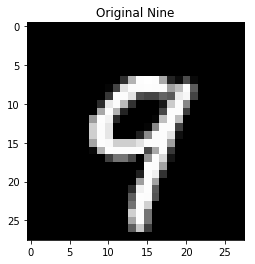

In [6]:
nine = test_dataset[12][0]
fig = plt.figure()
plt.imshow(nine.numpy().reshape((28,28)), cmap='gray')
plt.title('Original Nine')
None # avoid printing title object

## Hints:

- You are given a code skeleton with a few functions, but you will probably need to add some more arguments to the functions and their calls.
- Split the target "variable" i into a fixed part (where it is equal to nine) and a variable part (that is optimized; set requires_grad for this one). Both parts should be tensors and can be combined into another tensor representing i.
- Create these two tensors once and then have a function that combines them and calculates the loss.
- For the loss it is easiest to implement a function implements the loss translation for the less-or-equal ($\leq$) and less ($<$) operators from the lecutre. You can express all parts of the loss function with this. Make this parametric in the choice of d.
- If implemented correctly your code should not run more than a few seconds.
- There is no L-BFGS-B optimizer for pytroch yet. We provide a function that uses scipy to do this instead (see below).


In [7]:
a = np.array([[2,1], [3,4]])

In [24]:
class QueryNetwork:
    """
    Query a neural network. The constrains are hardcoded in this class.
    """

    def __init__(self, i_init, NN1_prop, NN2_prop, NN1_logits, NN2_logits, 
                 init_zero=False, learning_rate = 0.1, **kwargs):
        
        if init_zero:
            i_init = torch.zeros_like(i_init)
            
        i_temp = i_init.clone()
        self.i_fix = i_temp[0, :16, ...] # According to exersice sheet this part shall be fixed
        self.i_var = i_temp[0, 16:, ...] # According to exersice sheet this part shall be variable -> requieres grad
        self.i_var.requires_grad = True
        self.NN1_prop = NN1_prop
        self.NN2_prop = NN2_prop
        self.NN1_logits = NN1_logits
        self.NN2_logits = NN2_logits
        self.lbfgsb_NN1 = None
        self.lbfgsb_NN2 = None
        self.optimizer_sgd = optim.SGD([self.i_var], lr=learning_rate)
        self.optimizer_lbfgsb = lbfgsb([self.i_var], 0, 1, self.get_loss(), self.zero_grad())

        
    def get_i(self, **kwargs):
        """
        Concanate the fixed and the variable part of i
        """
        i = torch.cat((self.i_fix, self.i_var),0)
        i = i.reshape((1, 1, 28, 28))
        return i

    def get_loss(self, use_prob = None, use_logits =  None, add_bounds=False, **kwargs):
        
        loss = 0
        if use_prob is None and use_logits is None:
            use_prob=True
        
        if use_prob and use_logits:
            Exception("Inconsistent arguments, use_prob and use_logits are both 'True'.")
        
        elif use_prob:
            NN1_out = self.NN1_prop(self.get_i())
            NN2_out = self.NN2_prop(self.get_i())
        
        elif use_logits:
            NN1_out = self.NN1_logits(self.get_i())
            NN2_out = self.NN2_logits(self.get_i())
            
        # Calculate loss for constrain in exercise sheet: class (NN1( i ) ) = 8 
        # This is the same as stating that all probabilitiy outputs should be smaller than that of class 8.
        # <=> NN1(i)[k] < NN1(8)[k], for all k except 8
        loss += self.equal_to_label(NN1_out, 8, **kwargs)
        
        # Calculate loss for constrain in exercise sheet: class (NN2( i ) ) = 9 
        # This is the same as stating that all probabilitiy outputs should be smaller than that of class 8.
        # <=> NN2(i)[k] < NN2(9)[k], for all k except 9
        loss += self.equal_to_label(NN1_out, 9, **kwargs)
        
        # Add loss for values which are not in image domain.
        if add_bounds:
            i_var_flat = self.i_var.view(-1)
            for k in range(i_var_flat.size()[0]):
                loss += self.lower_equal(0, i_var_flat[k], **kwargs)
                loss += self.lower_equal(i_var_flat[k], 1, **kwargs)
            
        return loss
    
    def solve_gd(self,max_iter_=100, learning_rate=None, **kwargs):
        #return:
        #solved: Bool; did you find a solution
        #loss: Float; value of loss at the end    
        #i: numpy array; the resulting i
        #t: float; how long the execution took
        #nr: number of iterations
        
        t0 = time.time()
        loss = 0
        solved = False
        iter_ = 0
        
        if learning_rate is not None:
            for param_group in self.optimizer_sgd.param_groups:
                param_group['lr'] = learning_rate
        
        while iter_ <= max_iter_:
            iter_ += 1
            self.optimizer_sgd.zero_grad()   # zero the gradient buffers
            loss = self.get_loss(**kwargs)
            loss.backward()
            self.optimizer_sgd.step()    # Does the update


        solved = loss == 0
        t1 = time.time()

        return solved, loss, self.get_i().detach().numpy(), t1 - t0, iter_
    
    def solve_lbfgsb(**kwargs):
        t0 = time.time()
        loss = 0
        solved = False
        self.lbfgsb_NN1
        self.lbfgsb_NN2

        #return:
        #solved: Bool; did you find a solution
        #loss: Float; value of loss at the end    
        #i: numpy array; the resulting i
        #t: float; how long the execution took
        
        t1 = time.time()
        return solved, loss, nine.detach().numpy(), t1 - t0
    
    def zero_grad(self):
        self.lbfgsb_NN1.zero_grad()
        self.lbfgsb_NN2.zero_grad()
        self.i_var.zero_grad()

    
    def equal_to_label(self,NN_out, equal_label, **kwargs):
        loss = 0
        out_equal_label= NN_out[0][equal_label]
        for label in range(0,NN_out.shape[1]):
            if label == equal_label:
                continue
            loss += self.lower_strictly(NN_out[0][label], out_equal_label, **kwargs)
        
        return loss

    def lower_strictly(self, t1, t2, p=1, **kwargs):
        eps = np.finfo(float).eps
        return self.lower_equal(t1 + eps, t2, p=p, **kwargs)

    def lower_equal(self, t1, t2, p=1):
        if t1 < t2:
            return 0.0
        else:
            return self.distance(t1, t2, p=p)

    @staticmethod
    def distance(t1, t2, p=1):
        return torch.pow(abs(t1 - t2), p)

In [25]:
#feel free to add args to this function
def solve_lbfgsb(**kwargs):
    t0 = time.time()
    t1 = time.time()
    loss = 0
    solved = False

    #Hint:
    # Use the provided lbfgsb(var, min_val, max_val, loss_fn, zero_grad_fn)
    # function.
    # It takes the tensor to optimize (var), the min and max value for each entry (a scalar),
    # a function that returns the current loss-tensor and a function that sets the 
    # gradients of everything used (NN1_logits, NN2_logits) and i_var to zero.
    # This funciton does not return anything but changes var.

    
    #return:
    #solved: Bool; did you find a solution
    #loss: Float; value of loss at the end    
    #i: numpy array; the resulting i
    #t: float; how long the execution took
    return solved, loss, nine.detach().numpy(), t1 - t0

## using logits, initialized with zeros

In [26]:
nine = test_dataset[12][0]
qn_init_zero = QueryNetwork(nine, NN1, NN2, NN1_logits, NN2_logits, init_zero=True)

show(qn_init_zero.solve_gd(),
     qn_init_zero.solve_gd(add_bounds=True),
     qn_init_zero.solve_lbfgsb()
    )

AttributeError: 'QueryNetwork' object has no attribute 'solve_lbfgsb'

In [11]:
%debug


> <ipython-input-8-700e5e1080ec>(116)distance()
    112         return solved, loss, self.get_i.detach().numpy(), t1 - t0, iter_
    113 
    114     @staticmethod
    115     def distance(t1, t2, p=1):
--> 116         return abs(t1 - t2) ^ p

ipdb> t1 - t2
tensor(3.6870e-08, grad_fn=<ThSubBackward>)
ipdb> abs(t1 - t2)
tensor(3.6870e-08, grad_fn=<AbsBackward>)
ipdb> abs(t1 - t2) ^ p
*** RuntimeError: bitxor is only supported for integer type tensors at /pytorch/aten/src/TH/generic/THTensorMath.cpp:1225
ipdb> abs(t1 - t2)^torch.Tensor(1)
*** RuntimeError: cbitxor is only supported for integer type tensors at /pytorch/aten/src/TH/generic/THTensorMath.cpp:1813
ipdb> torch.pow(abs(t1 - t2),2(
*** SyntaxError: unexpected EOF while parsing
ipdb> torch.pow(abs(t1 - t2),2)
tensor(1.3594e-15, grad_fn=<PowBackward0>)
ipdb> q


Note that the first image has weird colors as not all values are in [0, 1].

## using logits, initialized with original image

In [ ]:
show(solve_gd(),
     solve_gd(add_bounds=True),
     solve_lbfgsb())

## using probabilites, initialized with zeros

In [ ]:
show(solve_gd(use_logits=False, init_zero=True),
     solve_gd(use_logits=False, init_zero=True),
     solve_lbfgsb(use_logits=False, init_zero=True))

## using probabilites, initialized with original image

In [ ]:
show(solve_gd(use_prob=True),
     solve_gd(add_bounds=True, use_prob=True),
     solve_lbfgsb(use_prob=True))

We see that using probabilities is not a viable approach. The numerical optimization problem becomes basically intractable due to the softmax function.

## different box constraint (task 1.7; optional), using logits

In [ ]:
show(solve_gd(box=2),
     solve_gd(add_bounds=True, box=2),
     solve_lbfgsb(box=2))

Since the region covered by box 2 is mostly emty it does not matter much wether we use init_zero or not.